## **AIStore w/ Dask**

[Dask](https://www.dask.org/) is a new and popular open-source Python library for parallel computing. Dask provides this parallel functionality for a single machine up to a distributed cluster.

#### **Pandas v. Dask**

For data scientists, [Pandas](https://pandas.pydata.org/) has long been the preferred tool for analyzing and manipulating data with Python. However, Dask provides similar capabilities, with the notable exception being Dask's *scalability* with dataset size. 

[Dask DataFrames](https://docs.dask.org/en/stable/dataframe.html) are essentially, a large, virtual dataframe divided along the index into multiple Pandas DataFrames. In fact, the `dask.DataFrame` API is a [subset](https://docs.dask.org/en/stable/dataframe.html#dask-dataframe-copies-the-pandas-dataframe-api) of `pd.DataFrame` API and should be familiar to those already familiar with [Pandas DataFrames](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

> For more information on Dask DataFrame API use, please refer to the [Dask DataFrame API reference](https://docs.dask.org/en/stable/dataframe-api.html).

Dask `DataFrames` support data access via HTTP(s) protocol and AIStore clusters support data access via [REST API](https://aiatscale.org/docs/http-api). REST API allows for data on AIStore to be read, written, and otherwise operated on via HTTP(s) verbs.

### <ins>**Getting Started**

Install Dask with `pip` as follows:

```console
$ python -m pip install dask
```

Install the latest AIStore release either with `conda` or `pip`:

```console
$ conda install aistore
```

```console
$ pip install aistore
```

Start by deploying an AIStore cluster. The following demonstrations will be utilizing a [Minikube (Kubernetes) deployment](https://github.com/NVIDIA/aistore/blob/master/deploy/dev/k8s/README.md) of AIStore. 

> For information on AIStore deployment options, refer [here](https://github.com/NVIDIA/aistore/blob/master/deploy/README.md).

Once deployed, import the `aistore` package and initialize a `Client`:

In [4]:
from aistore import Client

AIS_ENDPOINT = "http://192.168.49.2:8080"

# Initialize AIStore client
client = Client(AIS_ENDPOINT)

# Load sample data to AIStore for following demonstrations (Local to AIStore)
client.bucket("dask-demo-bucket").create()
client.bucket("dask-demo-bucket").object("zillow.csv").put("./data/zillow.csv")

# Verify that the object is in bucket
client.bucket("dask-demo-bucket").list_objects().get_entries()

[BucketEntry(name='zillow.csv', size=842, checksum='8b118b6e12d5b4b1', atime='15 Aug 22 15:13 UTC', version='', target_url='', copies=0, flags=64)]

### <ins>**ETL** (**E**xtract-**T**ransform-**L**oad)

**Note:** ETL processes using Dask with data on AIStore *are* possible, but has limitations as Dask does *not* currently support AIStore as a recognized storage provider. Refer to the AIS-ETL service [here](https://github.com/NVIDIA/aistore/blob/master/docs/etl.md), which offers both *offline* and *inline* custom transformations, as well as flexibility to the scope of those transformations (bucket-specific or object(s)-specific), and more.

#### **Extract:**

Initialize the Dask [`DataFrame`](https://docs.dask.org/en/stable/dataframe.html) with a direct HTTP(s) address to data residing on AIStore:

In [5]:
import dask.dataframe as dd


def read_csv_ais(bck_name: str, obj_name: str):
    return dd.read_csv(f"{AIS_ENDPOINT}/v1/objects/{bck_name}/{obj_name}")


# Initialize DataFrame
df = read_csv_ais(bck_name="dask-demo-bucket", obj_name="zillow.csv")

Dask `DataFrames` are split into smaller partitions and partitions are loaded into memory *as needed*. The method `head()` allows us to see just the first few lines of the data:

In [6]:
# View first partition of data
df.head()

,Index,"""Living Space (sq ft)""","""Beds""","""Baths""","""Zip""","""Year""","""List Price ($)"""
0,1,2222,3,3.5,32312,1981,250000
1,2,1628,3,2.0,32308,2009,185000
2,3,3824,5,4.0,32312,1954,399000
3,4,1137,3,2.0,32309,1993,150000
4,5,3560,6,4.0,32309,1973,315000


In [7]:
# View first two lines of data
df.head(2)

,Index,"""Living Space (sq ft)""","""Beds""","""Baths""","""Zip""","""Year""","""List Price ($)"""
0,1,2222,3,3.5,32312,1981,250000
1,2,1628,3,2.0,32308,2009,185000


#### **Transform:**

As mentioned before, Dask `DataFrames` are built on and in parallel with the Pandas API. The `dask.dataframe` API is very similar to the [Pandas](https://docs.dask.org/en/stable/dataframe.html#dask-dataframe-copies-the-pandas-dataframe-api) API and should be very familiar to those already familiar with Pandas:

In [8]:
# Print columns
print(df.columns)

# Filter datapoints for houses built AFTER the year 2000
df_new = df[df[' "Year"'] > 2000]
# Further filter for houses with a price less than $300,000
df_new_and_budget = df_new[df_new[' "List Price ($)"'] < 300000]
# Reindex
df_final = df_new_and_budget.reset_index()

# Verify that data has been correctly filtered
df_final.head()

Index(['Index', ' "Living Space (sq ft)"', ' "Beds"', ' "Baths"', ' "Zip"',
       ' "Year"', ' "List Price ($)"'],
      dtype='object')


,index,Index,"""Living Space (sq ft)""","""Beds""","""Baths""","""Zip""","""Year""","""List Price ($)"""
0,1,2,1628,3,2.0,32308,2009,185000
1,9,10,1997,3,3.0,32311,2006,295000
2,10,11,2097,4,3.0,32311,2016,290000
3,14,15,1381,3,2.0,32301,2006,143000


Dask also provides other tools that efficiently process a variety of different types of files, such as [images](https://examples.dask.org/applications/image-processing.html). The following snippet demonstrates image pre-processing capabilities with Dask using the [`dask-image`](https://github.com/dask/dask-image) module, similar to image transformations demonstrated with AIS-ETLs [here](https://aiatscale.org/blog/2021/10/22/ais-etl-2):

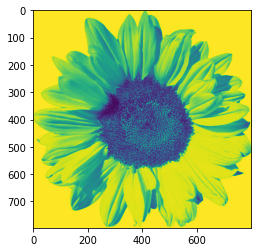

In [29]:
from nturl2path import url2pathname
import imageio.v3
from io import BytesIO
import matplotlib.pyplot as plt
import os
import requests

try:
    from skimage.io import imread as sk_imread
except (AttributeError, ImportError):
    pass

from dask.array.core import Array
from dask.base import tokenize


def add_leading_dimension(x):
    return x[None, ...]


def url_image_reader(url):
    response = requests.get(url)
    byte_content = BytesIO(response.content)
    image = imageio.v3.imread(byte_content)
    return image


# Modified version of dask.array.image.imread (doesn't use glob)
def custom_imread(filenames, imread=None, preprocess=None):
    """Read a stack of images into a dask array
    Parameters
    ----------
    filenames: list of strings
        A list of filename strings, eg: ['myfile._01.png', 'myfile_02.png']
    imread: function (optional)
        Optionally provide custom imread function.
        Function should expect a filename and produce a numpy array.
        Defaults to ``skimage.io.imread``.
    preprocess: function (optional)
        Optionally provide custom function to preprocess the image.
        Function should expect a numpy array for a single image.
    Examples
    --------
    >>> from dask.array.image import imread
    >>> im = imread('2015-*-*.png')  # doctest: +SKIP
    >>> im.shape  # doctest: +SKIP
    (365, 1000, 1000, 3)
    Returns
    -------
    Dask array of all images stacked along the first dimension.
    Each separate image file will be treated as an individual chunk.
    """
    imread = imread or sk_imread

    name = "imread-%s" % tokenize(filenames, map(os.path.getmtime, filenames))

    sample = imread(filenames[0])
    if preprocess:
        sample = preprocess(sample)

    keys = [(name, i) + (0,) * len(sample.shape) for i in range(len(filenames))]
    if preprocess:
        values = [
            (add_leading_dimension, (preprocess, (imread, fn))) for fn in filenames
        ]
    else:
        values = [(add_leading_dimension, (imread, fn)) for fn in filenames]
    dsk = dict(zip(keys, values))

    chunks = ((1,) * len(filenames),) + tuple((d,) for d in sample.shape)

    return Array(dsk, name, chunks, sample.dtype)


filenames = [f"{AIS_ENDPOINT}/v1/objects/dask-demo-bucket/sample-image.jpg"]
result = custom_imread(filenames, imread=url_image_reader)


# Pre-Processing function for image
def custom_filter(rgb):
    result = (rgb[..., 0] * 0.2125) + (rgb[..., 1] * 0.7154) + (rgb[..., 2] * 0.0721)
    return result


flower = result[0]
modified_flower = custom_filter(flower)

plt.imshow(modified_flower)

#### **Load:**

Dask *does* support many of the popular cloud storage providers (i.e. S3, GCP, Azure), and supports the direct writing of DataFrames as files to those services:

```python
# Write DataFrame as CSV to S3
dd.to_csv("s3://dask-demo-bucket/sample.csv")

# Write DataFrame as JSON to GCP
dd.to_json("gcs://dask-demo-bucket/sample.json")
```

> AIStore supports a subset of S3 API and Dask supports [S3-compatible storage services](https://docs.dask.org/en/stable/how-to/connect-to-remote-data.html#using-other-s3-compatible-services). However, Dask uses Boto3 for this and AIStore does not support Boto3 as it does not follow HTTP(s) protocol. For more information on AIStore compatibility with S3, refer [here](https://github.com/NVIDIA/aistore/blob/master/docs/s3compat.md).

While we cannot directly write to AIStore with Dask API (`dd.to_csv("ais://bucket/file.csv")` not supported as of now), we can convert the DataFrame to bytes and move it using AIStore's own API:

In [ ]:
# Convert to Pandas DataFrame
pd = df_new_and_budget.compute()
files = pd.to_csv(encoding="utf-8")

client.bucket("dask-demo-bucket").list_objects().get_entries()

client.bucket("dask-demo-bucket").object("formatted-zillow.csv").put(content=files)

print(type(files))

# Verify that the transformed file is now in the AIStore bucket
client.bucket("dask-demo-bucket").list_objects().get_entries()

However, the above method of converting a Dask DataFrame to a Pandas DataFrame may not be ideal as it defeats some of the performance advantages of using Dask. Converting a Dask DataFrame to a Pandas DataFrame only makes sense to do if the data can fully fit into memory (i.e. data has been filtered and is now much smaller).

For much larger datasets, [AIS-ETL](https://github.com/NVIDIA/aistore/blob/master/docs/etl.md) may offer better performance while offering similar ETL capabilities to those demonstrated above. Please refer [here](https://github.com/NVIDIA/aistore/blob/master/docs/etl.md) for more information.

### <ins>**Data Analysis** 

> Dask is not always the most efficient tool to be used in certain scenarios. Refer [here](https://docs.dask.org/en/latest/best-practices.html#start-small) for information on the best use-cases for Dask.

While Dask's use-cases with AIStore are quite limited as of now, it is still useful for performing data analysis with optimized memory usage. With Dask DataFrames, data can be analyzed **without** loading the entirety of the data into memory. More specifically, because Dask DataFrames (and most other Dask collections) are [lazy](https://saturncloud.io/blog/a-data-scientist-s-guide-to-lazy-evaluation-with-dask/), computations are executed only when the `dask.distributed.compute` method is called. As a result, specific parts of the data are loaded into memory as needed for the computations and are not loaded otherwise, optimizing memory usage:

In [ ]:
# Computations to be made (not computed until .compute() is called)
mean_price = df[' "List Price ($)"'].mean()
bed_sum = df[' "Beds"'].sum()
mean_size = df[' "Living Space (sq ft)"'].mean()

# Computes above in parallel
dd.compute({"price_mean": mean_price, "bed_sum": bed_sum, "mean_size": mean_size})

More examples of data analysis with Dask DataFrames can be found [here](https://examples.dask.org/dataframe.html) under Dask documentation.

### <ins>**References**

* [Dask API](https://docs.dask.org/en/stable/dataframe-api.html)
* [Pandas API](https://pandas.pydata.org/docs/reference/index.html)
* [AIStore Python SDK](https://github.com/NVIDIA/aistore/blob/master/docs/python_sdk.md)
* [AIS-ETL](https://github.com/NVIDIA/aistore/blob/master/docs/etl.md)